In [1]:
import sys
sys.path.insert(0, 'D:\My Work\Final Year Project\Main\FYP23-Deep-Document-Clustering\Transformer')

In [2]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import torch
import random

from utils.Encoder import Encoder

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


C:\Users\Faizan\AppData\Local\Temp\ipykernel_3208\1074084541.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Faizan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Available GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [5]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity

def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [6]:
def display_options(options):
    print("Select one of the following options:")
    for i, option in enumerate(options):
        print(f"{i + 1}. {option}")

def get_user_choice(options):
    while True:
        try:
            choice = int(input("Enter the number corresponding to your choice: "))
            if 1 <= choice <= len(options):
                return choice
            else:
                print("Invalid choice. Please enter a number within the range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

options = ["acm", "bbc","reut","cite", "doc50"]  # Sample options
display_options(options)
choice = get_user_choice(options)
print(f"You chose: {options[choice - 1]}")


Select one of the following options:
1. acm
2. bbc
3. reut
4. cite
5. doc50


Enter the number corresponding to your choice:  4


You chose: cite


In [7]:
x = np.loadtxt(f"data/{options[choice - 1]}.txt", dtype=float)
y = np.loadtxt(f"data/{options[choice - 1]}_label.txt", dtype=int)

In [8]:
x = torch.tensor(x, dtype=torch.float32)

In [9]:
x.device

device(type='cpu')

In [10]:
x.size()

torch.Size([3327, 3703])

In [11]:
# configurations for ACM
if(choice == 1):
   
    d_model = 1870
    num_heads = 1
    drop_prob = 0.1
    batch_size = 25
    max_sequence_length = 3025
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 3
    random_states = 500
    gpu = True

# configurations for BBC
elif(choice == 2):
    
    d_model = 9635
    num_heads = 1
    drop_prob = 0.1
    num_batches = 25
    max_sequence_length = 2225
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 5
    random_states = 500
    gpu = True

# configurations for Reuters
elif(choice == 3):
    
    d_model = 2000
    num_heads = 1
    drop_prob = 0.1
    num_batches = 25
    max_sequence_length = 10000
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 4
    random_states = 400
    gpu = True

# configurations for Citeseer
elif(choice == 4):
    
    d_model = 3703
    num_heads = 1
    drop_prob = 0.1
    num_batches = 3
    max_sequence_length = 3327
    ffn_hidden = 2048
    num_layers = 3
    n_clusters = 6
    random_states = 400
    gpu = True

# configurations for Doc50
elif(choice == 5):
    
    d_model = 3885
    num_heads = 1
    drop_prob = 0.1
    num_batches = 50
    max_sequence_length = 50
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 5
    random_states = 500
    gpu = False


In [12]:
if gpu and not torch.cuda.is_available():
    raise Exception("GPU is not available in this device")

In [13]:
from utils.PositionalEncoding import PositionalEncoding
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [14]:
dim_diff = d_model - positional_encoding.shape[1]  

if dim_diff != 0:
    positional_encoding = positional_encoding[:,0:dim_diff]

positional_encoding.size()

torch.Size([3327, 3703])

In [15]:
x = x + positional_encoding

In [16]:
try:
    x = x.reshape(shape=(num_batches, x.size()[0] // num_batches, x.size()[1]))
    print(x.size())
except Exception as e:
    raise Exception(e)

torch.Size([3, 1109, 3703])


In [17]:
if gpu:
    print("Moving feature tensor to GPU memory")
    x = x.cuda()
    print(x.device)
else:
    print("Feature tensor stored in CPU memory")
    print(x.device)

Moving feature tensor to GPU memory
cuda:0


In [18]:
%%time
reset_random_seeds(42)
if gpu:
    print("Developing encoder for GPU")
    encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers).cuda()
    torch.cuda.memory_allocated()
else:
    print("Developing encoder for CPU")
    encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers)

Developing encoder for GPU
CPU times: total: 812 ms
Wall time: 1.52 s


In [19]:
if gpu:
    for i in encoder.parameters():
        print(i.is_cuda)
else:
    print("Encoder in CPU")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [20]:
%%time
out = encoder(x)

x.size(): torch.Size([3, 1109, 3703])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.3878e-01,  ...,  1.0075e-04,
           1.0000e+00,  1.0025e-04],
         [ 9.0930e-01, -4.1615e-01,  9.1338e-01,  ...,  2.0150e-04,
           1.0000e+00,  2.0050e-04],
         ...,
         [ 1.5871e-01,  9.8732e-01,  8.1597e-01,  ...,  1.1120e-01,
           9.9380e-01,  1.1065e-01],
         [ 9.1656e-01,  3.9990e-01,  9.2913e-01,  ...,  1.1130e-01,
           9.9379e-01,  1.1075e-01],
         [ 8.3172e-01, -5.5519e-01,  1.9580e-01,  ...,  1.1140e-01,
           9.9378e-01,  1.1085e-01]],

        [[-1.7792e-02, -9.9984e-01, -7.1591e-01,  ...,  1.1150e-01,
           9.9376e-01,  1.1095e-01],
         [-8.5095e-01, -5.2525e-01, -9.7540e-01,  ...,  1.1160e-01,
           9.9375e-01,  1.1105e-01],
         [-9.0175e-01,  4.3226e-01, -3.4623e-01,  ...,  1.1170e-01,
           9.9374e-01,  1.1115e-01],
 

In [21]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    plt.show()


def calculate_purity(random_state, X, true_labels):
    clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=random_state, init='k-means++').fit(X).labels_
    purity = Purity_Score(true_labels, clusters)
    return random_state, purity

def KMeans_Labels_Parallel(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    global num_clusters
    num_clusters = n
    purity_collection = {}

    for i in range(0, rstate_limit, 100):
        # Use ThreadPoolExecutor to parallelize purity calculations
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(calculate_purity, i, X, true_labels): i for i in range(i, i+100)}
        temp_purity_collection = {future.result()[0]: future.result()[1] for future in futures}
        purity_collection.update(temp_purity_collection)

    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_assignments, cluster_centers


In [22]:
reshaped_out = out.reshape(out.size()[0] * out.size()[1], out.size()[2])
print(reshaped_out.size())
enhanced_x = reshaped_out.cpu().detach().numpy()

torch.Size([3327, 3703])


In [23]:
del reshaped_out
del out
del encoder
del x

Find best clusters for 400 random states
Maximum purity of 0.22572888488127443 found on random state 117


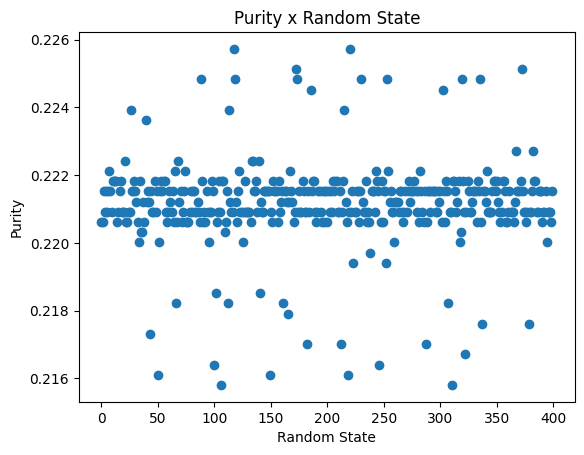

CPU times: total: 10min 28s
Wall time: 4min 6s


In [24]:
%%time
true_labels = y
print(f"Find best clusters for {random_states} random states")
pred_lables, centoids = KMeans_Labels_Parallel(enhanced_x, n_clusters, random_states, true_labels)

In [26]:
Evaluate(enhanced_x, true_labels, pred_lables)

Purity: 0.22572888488127443
Silhouette Score: 0.09029482305049896
ARI Score: 0.0023160399378406482
NMI Score: 0.00606138088104172


In [27]:
def visualize_clusters(X, cluster_assignments, cluster_centers, num_dimensions=2):
    # Apply PCA to reduce the dimensions for visualization
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Combine data and cluster assignments into a DataFrame
    data_with_clusters = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_dimensions+1)])
    data_with_clusters['Cluster'] = cluster_assignments

    # Scatter plot with different colors for each cluster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data_with_clusters, palette='viridis', s=80, alpha=0.8)
    
    # Plot cluster centers if available
    centers = pca.transform(cluster_centers)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


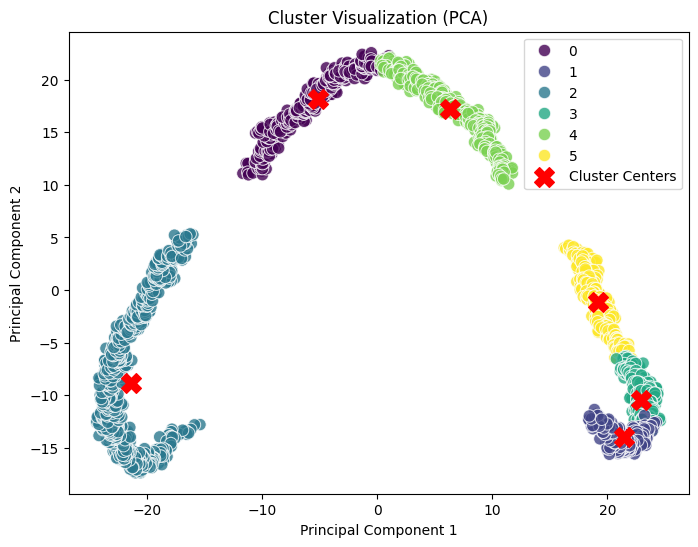

In [28]:
visualize_clusters(enhanced_x, pred_lables, cluster_centers=centoids, num_dimensions=2)

In [29]:
i=0
while i<len(true_labels):
    print(f"From {i} - {i+300}")
    print(true_labels[i:i+300])
    print(pred_lables[i:i+300])
    i+=300

From 0 - 300
[4 2 6 6 4 2 4 1 4 6 3 5 3 2 3 4 3 5 5 1 2 6 6 4 6 3 6 3 5 3 3 3 5 6 3 4 5
 6 4 4 3 2 3 2 6 2 2 5 3 4 4 3 6 3 6 2 5 2 5 3 3 4 5 6 6 2 4 4 5 3 5 2 2 6
 1 3 1 4 6 3 5 2 2 5 5 1 5 5 6 4 6 6 5 6 4 2 5 5 4 2 4 1 2 2 2 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 2 3 3 3 3 1 3 1 1 5 4 2 5 4 4 4 3 2 6 2 3 5 3 3 2 3 3
 4 2 2 2 3 3 3 4 6 3 2 5 1 3 3 4 4 3 4 6 6 3 4 5 4 5 4 6 5 4 5 4 3 3 5 4 3
 6 4 4 6 4 6 6 4 3 5 4 4 3 1 4 3 1 4 5 1 5 3 2 2 2 2 2 5 3 6 5 2 4 2 4 3 2
 6 4 3 6 5 6 5 3 6 3 6 4 5 3 6 2 3 2 2 4 3 3 6 4 3 1 2 6 4 1 6 6 6 4 3 1 3
 5 4 4 1 3 4 5 6 3 4 2 2 2 5 4 6 4 1 4 4 4 4 2 2 5 5 5 4 2 4 3 4 6 2 5 5 3
 3 2 3 3]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2